# Searching for digit manifolds

In this notebook, we'll calculate the level of agreement between elements of a class of digits. The intention is to use the similarity of class elements to sort the elements into a manifold (each successive element appears to be a slight perturbation or continuous deformation of the previous element).

There are 10 classes of digits 0-9. Let $A$ and $B$ be elements of class $N$. For current purposes, the distance between $A$ and $B$ is given by

$$
    ||A - B||_F,
$$
where $||\cdot||_F$ represents the Frobenius norm.

The first few cells of the notebook are just data management and sorting. 

In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import morphology as morph
from scipy.signal import fftconvolve, correlate
import numpy.linalg as LA
from sklearn.datasets import fetch_openml

In [2]:
# Load MNIST data from https://www.openml.org/d/554
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
''' Right now the images and labels are in separate arrays. 
    I'll put them into a single pandas DataFrame to make it
    easier to sort by label.
'''

images = pd.DataFrame(zip(images,labels), columns = ['Image','Class label'])

# Not really necessary, but I'll sort the images by class label.
images.sort_values(by = 'Class label', inplace = True)

# By default, the 'Class label' column is not integer, so we'll convert it here.
images['Class label'] = images['Class label'].apply(int)

# The images are also flattened, so we'll reshape them to (28,28)
images['Image'] = images['Image'].apply(lambda x: x.reshape((28,28)))

In [4]:
def extract_image(frame, digit):
    """ This function takes in a dataset containing images. 
        The set is converted to a DataFrame, and the images
        corresponding to the given digit are extracted.
        
        An array containing images of the given digit is
        returned.
    """
        
    ims = frame[frame['Class label'] == digit]
    
    # Now ims only contains labels matching the digit, so we can drop the label column.
    ims = ims.drop('Class label', axis = 1)
    
    return np.array(ims['Image'])

def display_lengths(data):
    """ Display the total length of each subset of digits. 
    
        Used for checking that the conversion worked as expected.
    """
    
    for i in range(10):
        print('{} examples of digit {}'.format(len(data[i]), i))
    print('{} examples in total\n'.format(sum(len(data[i]) for i in range(10))))
    return None

In [32]:
data = [extract_image(images, i) for i in range(10)]
display_lengths(data)

6903 examples of digit 0
7877 examples of digit 1
6990 examples of digit 2
7141 examples of digit 3
6824 examples of digit 4
6313 examples of digit 5
6876 examples of digit 6
7293 examples of digit 7
6825 examples of digit 8
6958 examples of digit 9
70000 examples in total



In [6]:
# Finally, save each digit separately

zero = data[0]
one = data[1]
two = data[2]
three = data[3]
four = data[4]
five = data[5]
six = data[6]
seven = data[7]
eight = data[8]
nine = data[9]

# Calculating the agreement between classes

We'll take samples from a class and calculate the sample variance. Next, we calculate the agreement within the sample.

In [7]:
# Take N samples from each digit

N = 250

sample0 = zero[:N]
sample1 = one[:N]
sample2 = two[:N]
sample3 = three[:N]
sample4 = four[:N]
sample5 = five[:N]
sample6 = six[:N]
sample7 = seven[:N]
sample8 = eight[:N]
sample9 = nine[:N]

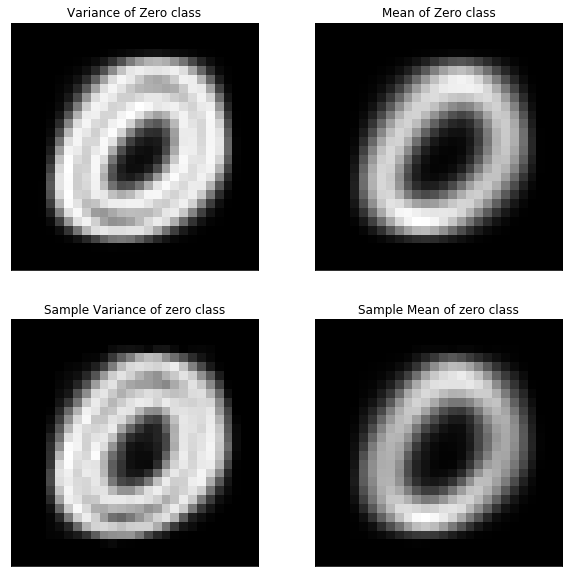

In [8]:
# Variance of the zero digits

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax

ax[0,0].imshow(zero.var(), cmap = 'gray')
ax[0,0].set(title = 'Variance of Zero class', xticks = [], yticks = []);

ax[0,1].imshow(zero.mean(), cmap = 'gray')
ax[0,1].set(title = 'Mean of Zero class', xticks = [], yticks = []);

ax[1,0].imshow(sample0.var(), cmap = 'gray')
ax[1,0].set(title = 'Sample Variance of zero class', xticks = [], yticks = []);

ax[1,1].imshow(sample0.mean(), cmap = 'gray')
ax[1,1].set(title = 'Sample Mean of zero class', xticks = [], yticks = []);

# plt.imshow(zero.var(), cmap = 'gray');

# Finding the families for the zero digit class

The algorithm below calculates the agreement between all elements in a sample of the zero digits. We then sort the elements into 'families', where the 'siblings' in each family are given by agreement over 80%. 

When each family is identified, we take the mean image of each family.

**Note:** When I programmed this, I was using 'chain' instead of 'family'. We'll take that to mean the same thing for now and I'll change it later.

In [35]:
distance = [LA.norm(A-B,'fro') for A in sample0 for B in sample0]

In [18]:
dist_chart = pd.DataFrame(np.array(distance).reshape(N,N))
dist_chart[dist_chart == 0.0] = np.nan
dist_chart

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,NaN,2417.260846,1837.475442,3101.254424,1443.170122,2180.883766,2467.329528,2431.790493,2955.406402,2222.081907,...,2428.464124,1807.847892,1775.443043,2622.165136,2461.835494,1754.651247,2811.885666,3062.352364,2931.985334,2760.381133
1,2417.260846,NaN,1655.749981,2548.322782,1835.711851,1678.054826,2367.751465,1565.004473,1885.544749,1452.785600,...,1499.503251,2031.025849,1964.781922,1922.517100,2862.580654,2004.069610,2046.312537,2469.498735,2530.526427,2074.962650
2,1837.475442,1655.749981,NaN,2721.957200,1234.780952,1518.894993,2042.589778,1834.634841,2370.707700,1545.364682,...,1939.855149,1520.345356,2007.413261,2011.202128,2621.955377,1895.132449,2388.819583,2720.337111,2600.503028,2466.932103
3,3101.254424,2548.322782,2721.957200,NaN,2858.195410,2673.148144,2522.632752,2353.864907,2139.366261,2460.166864,...,2589.762344,2791.958990,2770.776606,2617.137941,3225.423228,2993.990982,1916.671072,2442.140659,1631.277720,2600.284408
4,1443.170122,1835.711851,1234.780952,2858.195410,NaN,1666.340901,2203.355850,2014.221189,2618.078494,1750.983724,...,2126.621264,1476.589313,1639.856091,2139.606973,2400.644497,1738.163111,2424.651109,2711.872416,2754.253438,2533.279692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1754.651247,2004.069610,1895.132449,2993.990982,1738.163111,1891.327840,2352.289948,2020.029703,2860.025524,1740.633505,...,1850.011081,2334.469747,1406.991471,2518.457266,2909.645511,NaN,2662.807916,2968.643293,2829.812891,2474.230992
246,2811.885666,2046.312537,2388.819583,1916.671072,2424.651109,2312.284801,2231.941307,1959.495343,1941.238265,2083.939299,...,2291.354403,2303.446765,2457.869606,2157.204441,3007.692637,2662.807916,NaN,2140.174058,2040.571734,1977.460240
247,3062.352364,2469.498735,2720.337111,2442.140659,2711.872416,2360.422420,2489.706208,2647.679928,2372.758943,2628.869339,...,2696.662011,2689.955018,2838.392150,2914.201091,3228.385665,2968.643293,2140.174058,NaN,2491.880816,2547.382578
248,2931.985334,2530.526427,2600.503028,1631.277720,2754.253438,2556.771010,2445.574166,2363.839039,2448.600212,2500.276385,...,2493.725326,2689.943866,2768.182075,2577.529437,3155.091758,2829.812891,2040.571734,2491.880816,NaN,2599.379541


In [31]:
dist_chart.idxmin(axis = 1, skipna = True)

0      127
1      232
2        4
3       43
4       62
      ... 
245    132
246     24
247     91
248    130
249     24
Length: 250, dtype: int64

In [26]:
def get_manifold(dist_chart, start_row = 0):
    """ Get the manifold represented by the sample digits in dist_chart. """
    
    manifold = []  
    
    # Find the two most dissimilar digits and make them the boundaries of the manifold
    print(np.nanmax(dist_chart.values))
#     print(dist_chart)
    
#     return manifold
#     while not dist_chart.empty:
#         chain = [start_row]

#         ag_chart.drop(start_row, axis = 1, inplace = True)

#         while ag_chart.loc[start_row].max() > threshold:
            
#             # Find the column that corresponds to the next row to search
#             next_row = ag_chart.loc[start_row].idxmax(axis = 0)
#             ag_chart.loc[start_row] = 0

#             start_row = next_row
#             # Drop the column we just searched
#             ag_chart.drop(start_row, axis = 1, inplace = True)

#             chain.append(start_row)
        
#         ag_chart.drop(chain, axis = 0, inplace = True)
#         chains.append(chain)
    
#         try:
#             start_row = ag_chart.index[0]
#         except:
#             break
            
#     return chains

get_manifold(dist_chart)

3817.0142782022704
53


This next cell finds the chains of digits that have agreement of more than 80%.

In [14]:
threshold = 0.8

families = get_chains(agree_chart, threshold = threshold)
print(families)

[[0, 127, 187, 149, 163, 4, 75, 99, 67, 1, 222, 165, 140, 49, 215, 145, 229, 156, 82, 36, 43, 142, 95, 121, 169, 61, 72, 31, 137, 63, 93, 158, 122, 92, 53, 48, 55, 244, 87, 83, 238, 131, 120, 129, 114, 73, 189, 239, 224, 90, 37, 220, 181, 206, 160, 116, 133, 159, 144, 109, 107, 104, 69, 193, 182, 245, 132, 154, 242, 51, 86, 64, 112, 54, 240, 71, 201, 214, 217, 227, 236, 209, 190, 20, 9, 7, 25, 161, 213, 150, 170, 108, 118, 35, 196, 58, 166, 194, 94, 233, 65, 198, 77, 26, 56, 225, 134, 79, 172, 80, 106, 148, 101, 24, 246, 249, 97, 232, 192, 68, 10, 32, 30, 21, 3, 19, 167, 130, 176, 76, 237, 205, 208, 202, 157, 23, 155, 151, 186, 8, 91, 41], [2, 11, 178, 146, 96, 128, 110, 102, 119, 14, 219, 46, 50, 226, 29, 62, 47, 175, 180, 228, 174, 195, 59, 230], [5, 235, 17, 152, 218, 212, 136, 66, 85], [6], [12, 243], [13, 22, 103, 177, 216, 135, 60, 168, 200, 153, 113, 197, 78, 147, 143, 184], [15, 207, 231, 241, 34], [16, 42, 45], [18, 38], [27], [28, 191, 74], [33], [39, 81, 185, 52], [40, 117],

Algorithm found 36 families of digits with threshold 0.8.


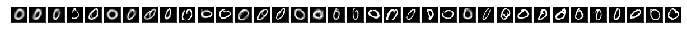

In [15]:
def display_chain(chains, sample):
    """ Display the mean digit obtained by averaging over each chain of digits. """
    
    ims = [sum(sample[i] for i in chain)/len(chain) for chain in chains]
    
    print('Algorithm found {} families of digits with threshold {}.'.format(len(chains), threshold))
    
    fig, ax = plt.subplots(1,len(ims),figsize=(12,12))
    
    for i in range(len(ims)):
        ax[i].imshow(ims[i], cmap = 'gray');
        ax[i].set(xticks = [], yticks = []);
    return None

display_chain(families, sample0)

In the output above, families with more than one member have their 'family mean' displayed (the mean of all images in the family).

## Finding family means for every digit class

This is working really well for finding chains of similar digits. Now I'll perform the algorithm on each digit class.

In [16]:
samples = [sample0, sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8, sample9]

In [17]:
def similarity(sample):
    """ Find the similarity matrix for a sample taken from a class of digits. """
    
    agree = [LA.norm(A*B,2)/(np.sqrt(LA.norm(A*A,2))*np.sqrt(LA.norm(B*B,2))) for A in sample for B in sample]
    
    agree_chart = pd.DataFrame(np.array(agree).reshape(N,N))
    agree_chart[agree_chart > 0.99] = 0
    
    return agree_chart

In [18]:
# Find the agreement chart for all samples.
agreement_charts = [similarity(sample) for sample in samples]

In [19]:
# Find the chains of similar digits for all digit classes.

all_families = {key:get_chains(ag, threshold = threshold) for key,ag in zip(range(len(agreement_charts)),agreement_charts)}

Algorithm found 36 families of digits with threshold 0.8.
Algorithm found 8 families of digits with threshold 0.8.
Algorithm found 66 families of digits with threshold 0.8.
Algorithm found 56 families of digits with threshold 0.8.
Algorithm found 37 families of digits with threshold 0.8.
Algorithm found 73 families of digits with threshold 0.8.
Algorithm found 45 families of digits with threshold 0.8.
Algorithm found 34 families of digits with threshold 0.8.
Algorithm found 65 families of digits with threshold 0.8.
Algorithm found 33 families of digits with threshold 0.8.


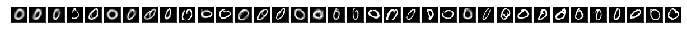

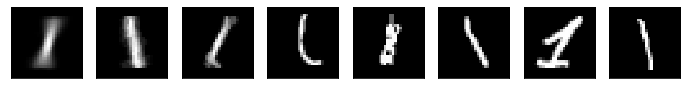

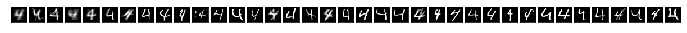

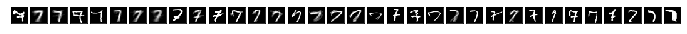

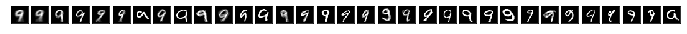

In [20]:
for key, sample in zip(all_families, samples):
    display_chain(all_families[key], sample)

# Computing projections onto the bases

- take some random examples of digits, calculate the agreement with each basis; take largest value as the class

Further ideas:
- reduce the basis size

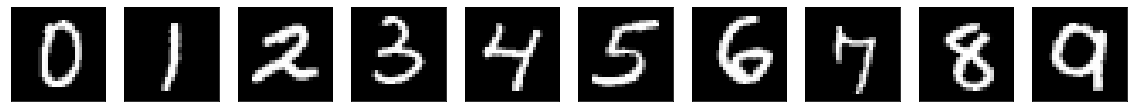

In [43]:
# Selecting test digits, 1 from each class

testing = [np.random.choice(data[i][500:]) for i in range(10)]

# Show the test digits
fig, ax = plt.subplots(1, 10, figsize = (20,4))

for i in range(10):
    ax[i].imshow(testing[i], cmap = 'gray')
    ax[i].set(xticks = [], yticks = []);

In [233]:
# Computing similarity of the test digits with the computed digit families - highest agreement indicates the digit class

def project_test_digit(digit, family):
    """ Calculate the projection of 'digit' onto a 'family' of digits. """
    
    coef = [LA.norm(digit*B,'fro')/(np.sqrt(LA.norm(digit*digit,'fro'))*np.sqrt(LA.norm(B*B,'fro'))) for B in family]
    
    mean_agreement = np.mean(coef)
    return mean_agreement

def mean_digits(family, sample):
    """ Take a family of digits, compute the mean image for long families. """
    
    ims = [sum(sample[i] for i in chain)/len(chain) for chain in family]
    print('{} images computed for family of length {}'.format(len(ims), len(family)))
    
    return ims

bases = {}

# Get the mean image for families with length greater than 1
for key, sample, index in zip(all_families, samples, range(10)):
    bases[index] = mean_digits(all_families[key], sample)
    

36 images computed for family of length 36
8 images computed for family of length 8
66 images computed for family of length 66
56 images computed for family of length 56
37 images computed for family of length 37
73 images computed for family of length 73
45 images computed for family of length 45
34 images computed for family of length 34
65 images computed for family of length 65
33 images computed for family of length 33


In [245]:
""" This calculates the projection of each testing digit onto every basis in 'bases'.
"""

projections = [[project_test_digit(digit, bases[j]) for j in range(10)] for digit in testing]

In [255]:
# Finally, determining the class label for the testing images

def get_labels(projections):
    """ Calculate the class labels for each testing digit. """
    
    msg = 'Test digit {} is most likely in class {}'
    
    labels = [np.argmax(proj) for proj in projections]
    
    for i in range(len(projections)):
        print(msg.format(i, labels[i]))
        
    return list(zip(range(len(projections)),labels))

In [256]:
np.argmax(projections)

88

In [257]:
get_labels(projections)

Test digit 0 is most likely in class 0
Test digit 1 is most likely in class 1
Test digit 2 is most likely in class 9
Test digit 3 is most likely in class 3
Test digit 4 is most likely in class 9
Test digit 5 is most likely in class 0
Test digit 6 is most likely in class 6
Test digit 7 is most likely in class 9
Test digit 8 is most likely in class 8
Test digit 9 is most likely in class 0


[(0, 0),
 (1, 1),
 (2, 9),
 (3, 3),
 (4, 9),
 (5, 0),
 (6, 6),
 (7, 9),
 (8, 8),
 (9, 0)]

In [ ]:
def classification_error(result):
    pass